In [1]:
!git clone https://github.com/deepanshudashora/custom_models.git

Cloning into 'custom_models'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 22 (delta 6), reused 15 (delta 4), pack-reused 0
Unpacking objects: 100% (22/22), 7.08 KiB | 1.18 MiB/s, done.


In [2]:
!pip3 install torch_lr_finder
!pip3 install torchinfo

In [3]:
# Initialized Logger
import torch
import torch.optim as optim
from torchvision import datasets
import albumentations as A
from torchsummary import summary
from albumentations.pytorch import ToTensorV2
from custom_models.utils import get_device, \
                  fit_model, plot_accuracy_report, \
                  show_random_results, plot_misclassified, \
                  calculate_accuracy_per_class
from custom_models.dataset import dataset_stats,\
                        visualize_images,\
                        visualize_augmentated_images,\
                        Cifar10SearchDataset
from custom_models.custom_resnet import CustomResnet

CODE BLOCK: 2

In [4]:
# CUDA?
device = get_device()
print("Available Device :: ", device)

INFO:custom_models.utils:device: cuda


Available Device ::  cuda


CODE BLOCK: 3

In [5]:
sample = datasets.CIFAR10('./data',train=True,download=True)
sample_data = sample.data

mean,std,var = dataset_stats(sample_data)
print(f"SHAPE of Images {sample_data.shape}")
print(f"MEAN of dataset {mean}")
print(f"STD of dataset {std}")
print(f"VAR of dataset {var}")

100%|██████████| 170498071/170498071 [00:03<00:00, 47187825.80it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
SHAPE of Images (50000, 32, 32, 3)
MEAN of dataset [0.49139968 0.48215841 0.44653091]
STD of dataset [0.24703223 0.24348513 0.26158784]
VAR of dataset [15.56135559 15.11767693 17.44919073]


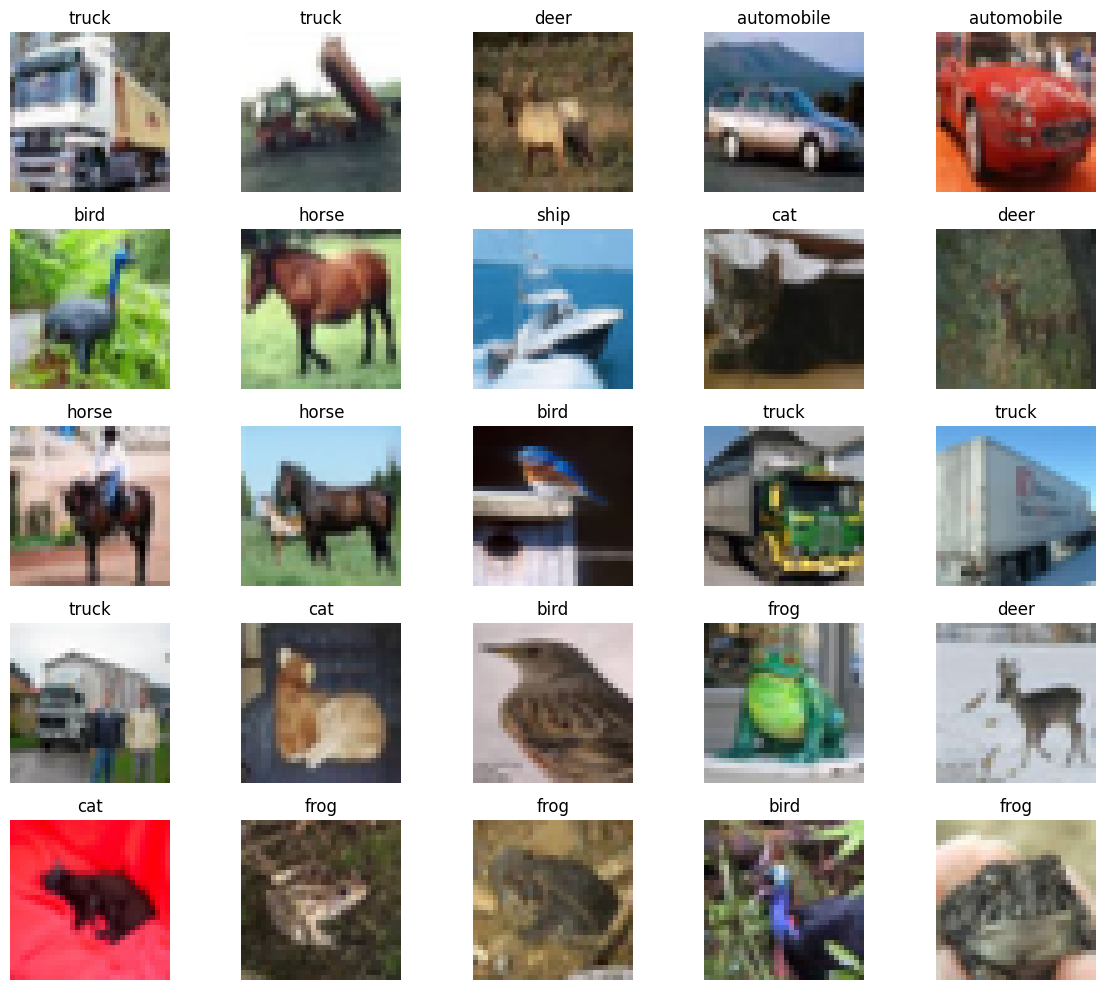

In [6]:
visualize_images(sample,(5,5))

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:133: FutureWarning: IAAFliplr is deprecated. Please use HorizontalFlip instead.
  warnings.warn("IAAFliplr is deprecated. Please use HorizontalFlip instead.", FutureWarning)


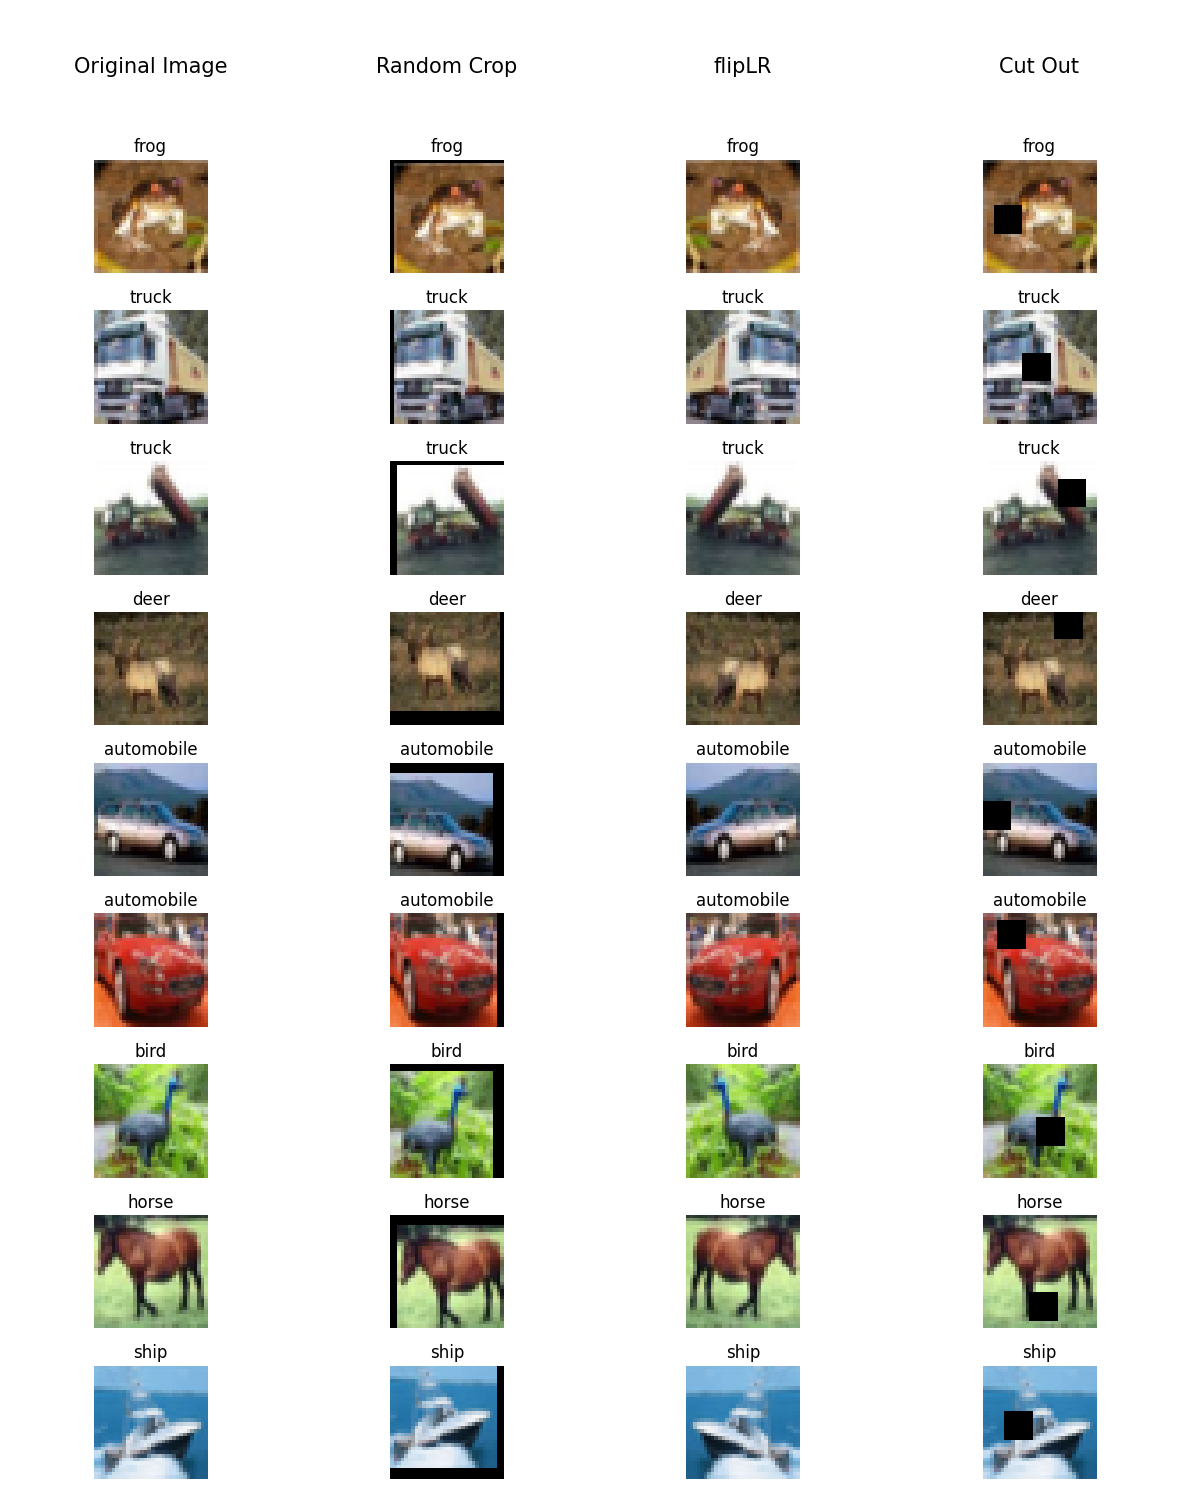

In [7]:
aug_details = {
    'Original Image': None,
    'Random Crop': A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 4, keep_size=True by default
                  A.RandomCrop(32,32)]),
    'flipLR':A.IAAFliplr (always_apply=True),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8,
                               min_width=8, fill_value=[0.49139968, 0.48215841, 0.44653091], always_apply=True),
      }

visualize_augmentated_images(sample,aug_details)

In [8]:
train_transforms = A.Compose(
    [
      A.Normalize(mean, std),
      A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 4, keep_size=True by default
                  A.RandomCrop(32,32)]),
      A.IAAFliplr(always_apply=True),
      A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8,
                            min_width=8, fill_value=[0.49139968, 0.48215841, 0.44653091], always_apply=True),
      ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
      A.Normalize(mean, std),
      ToTensorV2(),
    ]
)

train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


In [9]:
from torchinfo import summary
model = CustomResnet().to(device)
summary(model, input_size=(512,3, 32, 32),depth=4)

Layer (type:depth-idx)                   Output Shape              Param #
CustomResnet                             [512, 10]                 --
├─Sequential: 1-1                        [512, 64, 32, 32]         --
│    └─Conv2d: 2-1                       [512, 64, 32, 32]         1,728
│    └─BatchNorm2d: 2-2                  [512, 64, 32, 32]         128
│    └─ReLU: 2-3                         [512, 64, 32, 32]         --
├─Sequential: 1-2                        [512, 128, 16, 16]        --
│    └─Conv2d: 2-4                       [512, 128, 32, 32]        73,728
│    └─MaxPool2d: 2-5                    [512, 128, 16, 16]        --
│    └─BatchNorm2d: 2-6                  [512, 128, 16, 16]        256
│    └─ReLU: 2-7                         [512, 128, 16, 16]        --
├─Sequential: 1-3                        [512, 128, 16, 16]        --
│    └─Conv2d: 2-8                       [512, 128, 16, 16]        147,456
│    └─BatchNorm2d: 2-9                  [512, 128, 16, 16]        256


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.31E-02


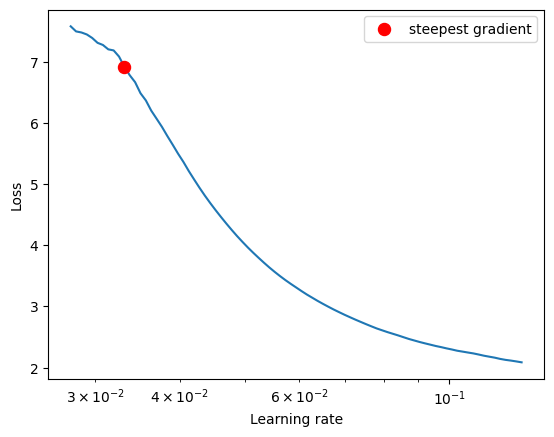

In [10]:
# LR calculation
from torch_lr_finder import LRFinder

model = CustomResnet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.023, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=0.14, num_iter=100, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [11]:
training_parameters = {"learning_rate":0.023,
                       "max_lr":3.31E-02,
                       "max_at":5/24,
                       "num_epochs":24,
                       "weight_decay":1e-4
                       }
train_losses, test_losses, train_acc, test_acc = fit_model(model,training_parameters,train_loader,test_loader,device)

Epoch 1


Train: Loss=1.0585 Batch_id=97 Accuracy=49.95: 100%|██████████| 98/98 [00:50<00:00,  1.96it/s]


Test set: Average loss: 0.0349, Accuracy: 5738/10000 (57.38%)

Epoch 2


Train: Loss=0.7703 Batch_id=97 Accuracy=66.42: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s]


Test set: Average loss: 0.0245, Accuracy: 6699/10000 (66.99%)

Epoch 3


Train: Loss=0.6567 Batch_id=97 Accuracy=70.37: 100%|██████████| 98/98 [00:50<00:00,  1.93it/s]


Test set: Average loss: 0.0263, Accuracy: 6546/10000 (65.46%)

Epoch 4


Train: Loss=0.6619 Batch_id=97 Accuracy=75.54: 100%|██████████| 98/98 [00:50<00:00,  1.93it/s]


Test set: Average loss: 0.0230, Accuracy: 7249/10000 (72.49%)

Epoch 5


Train: Loss=0.6379 Batch_id=97 Accuracy=75.98: 100%|██████████| 98/98 [00:50<00:00,  1.92it/s]


Test set: Average loss: 0.0287, Accuracy: 6739/10000 (67.39%)

Epoch 6


Train: Loss=0.6951 Batch_id=97 Accuracy=77.98: 100%|██████████| 98/98 [00:50<00:00,  1.96it/s]


Test set: Average loss: 0.0177, Accuracy: 7790/10000 (77.90%)

Epoch 7


Train: Loss=0.7374 Batch_id=97 Accuracy=79.24: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.0224, Accuracy: 7279/10000 (72.79%)

Epoch 8


Train: Loss=0.5459 Batch_id=97 Accuracy=80.16: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.0203, Accuracy: 7492/10000 (74.92%)

Epoch 9


Train: Loss=0.4918 Batch_id=97 Accuracy=80.21: 100%|██████████| 98/98 [00:50<00:00,  1.92it/s]


Test set: Average loss: 0.0155, Accuracy: 7918/10000 (79.18%)

Epoch 10


Train: Loss=0.5293 Batch_id=97 Accuracy=81.15: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s]


Test set: Average loss: 0.0219, Accuracy: 7784/10000 (77.84%)

Epoch 11


Train: Loss=0.5307 Batch_id=97 Accuracy=81.80: 100%|██████████| 98/98 [00:49<00:00,  2.00it/s]


Test set: Average loss: 0.0213, Accuracy: 7422/10000 (74.22%)

Epoch 12


Train: Loss=0.4795 Batch_id=97 Accuracy=82.46: 100%|██████████| 98/98 [00:49<00:00,  1.98it/s]


Test set: Average loss: 0.0234, Accuracy: 7605/10000 (76.05%)

Epoch 13


Train: Loss=0.4768 Batch_id=97 Accuracy=82.20: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s]


Test set: Average loss: 0.0150, Accuracy: 7748/10000 (77.48%)

Epoch 14


Train: Loss=0.6099 Batch_id=97 Accuracy=83.31: 100%|██████████| 98/98 [00:48<00:00,  2.01it/s]


Test set: Average loss: 0.0133, Accuracy: 8253/10000 (82.53%)

Epoch 15


Train: Loss=0.4904 Batch_id=97 Accuracy=83.87: 100%|██████████| 98/98 [00:48<00:00,  2.00it/s]


Test set: Average loss: 0.0227, Accuracy: 7664/10000 (76.64%)

Epoch 16


Train: Loss=0.5543 Batch_id=97 Accuracy=84.14: 100%|██████████| 98/98 [00:48<00:00,  2.01it/s]


Test set: Average loss: 0.0154, Accuracy: 8217/10000 (82.17%)

Epoch 17


Train: Loss=0.4327 Batch_id=97 Accuracy=85.48: 100%|██████████| 98/98 [00:49<00:00,  1.98it/s]


Test set: Average loss: 0.0140, Accuracy: 8207/10000 (82.07%)

Epoch 18


Train: Loss=0.4769 Batch_id=97 Accuracy=86.21: 100%|██████████| 98/98 [00:49<00:00,  1.98it/s]


Test set: Average loss: 0.0147, Accuracy: 8451/10000 (84.51%)

Epoch 19


Train: Loss=0.4433 Batch_id=97 Accuracy=87.25: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s]


Test set: Average loss: 0.0136, Accuracy: 8361/10000 (83.61%)

Epoch 20


Train: Loss=0.3357 Batch_id=97 Accuracy=88.59: 100%|██████████| 98/98 [00:49<00:00,  2.00it/s]


Test set: Average loss: 0.0109, Accuracy: 8654/10000 (86.54%)

Epoch 21


Train: Loss=0.2772 Batch_id=97 Accuracy=90.04: 100%|██████████| 98/98 [00:48<00:00,  2.00it/s]


Test set: Average loss: 0.0110, Accuracy: 8630/10000 (86.30%)

Epoch 22


Train: Loss=0.2853 Batch_id=97 Accuracy=92.01: 100%|██████████| 98/98 [00:49<00:00,  2.00it/s]


Test set: Average loss: 0.0068, Accuracy: 8832/10000 (88.32%)

Epoch 23


Train: Loss=0.1855 Batch_id=97 Accuracy=93.81: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s]


Test set: Average loss: 0.0094, Accuracy: 8973/10000 (89.73%)

Epoch 24


Train: Loss=0.1187 Batch_id=97 Accuracy=95.88: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s]


Test set: Average loss: 0.0084, Accuracy: 9091/10000 (90.91%)



In [12]:
test_loss_cpu = []
for i in test_losses:
  test_loss_cpu.append(i.cpu().numpy())

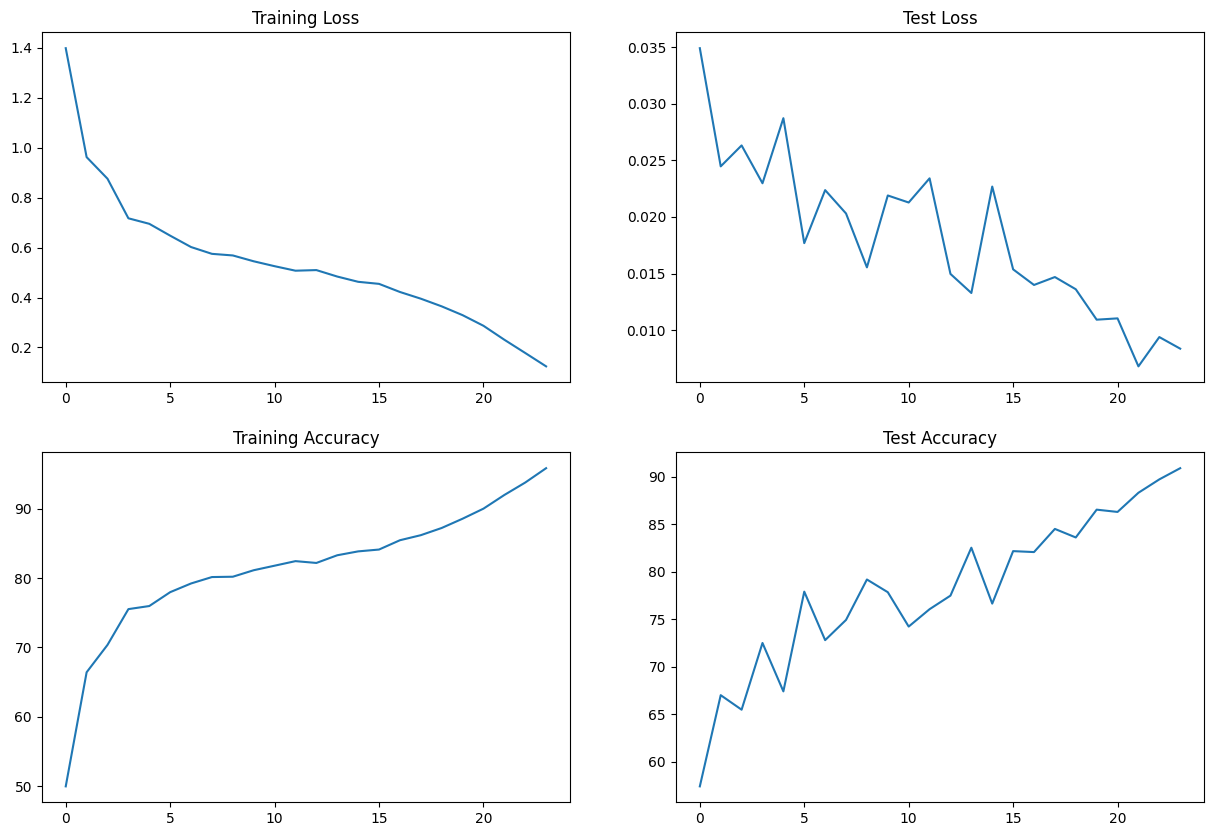

In [13]:
plot_accuracy_report(train_losses, test_loss_cpu, train_acc, test_acc)

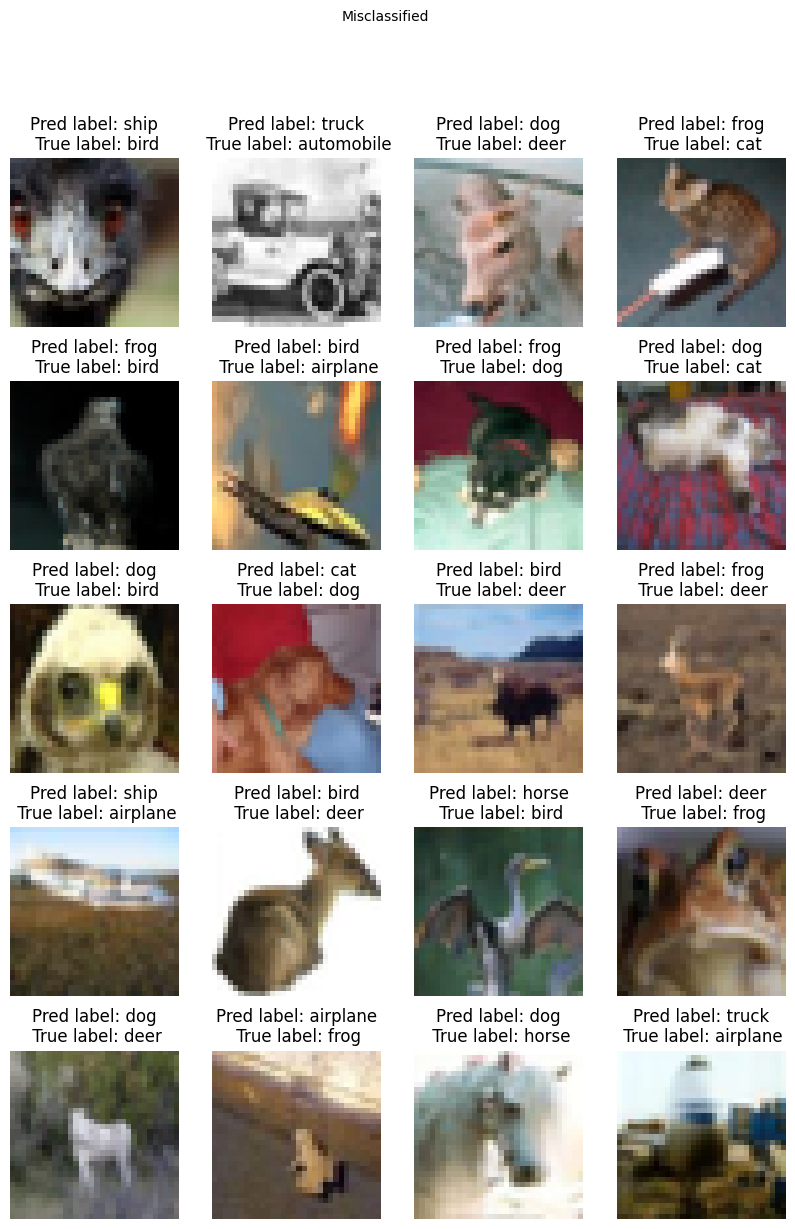

In [14]:
# from torchvision import transforms
# import matplotlib.pyplot as plt
# import numpy as np

grid_size = (4,4)
plot_misclassified(model,test_loader,test,device,mean,std)


Accuracy of airplane : 95 %

Accuracy of automobile : 100 %

Accuracy of  bird : 90 %

Accuracy of   cat : 83 %

Accuracy of  deer : 84 %

Accuracy of   dog : 92 %

Accuracy of  frog : 85 %

Accuracy of horse : 80 %

Accuracy of  ship : 100 %

Accuracy of truck : 100 %
{'airplane': 95.65217391304348, 'automobile': 100.0, 'bird': 90.47619047619048, 'cat': 83.33333333333333, 'deer': 84.61538461538461, 'dog': 92.0, 'frog': 85.71428571428571, 'horse': 80.0, 'ship': 100.0, 'truck': 100.0}


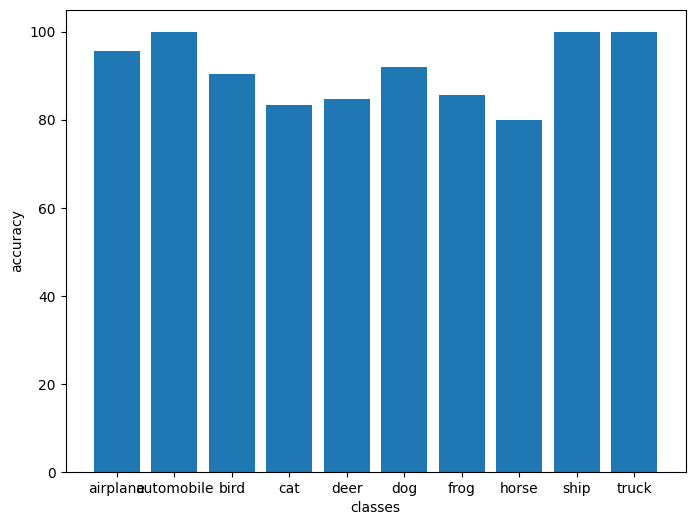

In [15]:
calculate_accuracy_per_class(model,device,test_loader,test)

In [16]:
torch.save(model.state_dict(), "cifar_85.pth")